# core

> Fill in a module description here

In [2]:
#| default_exp preprocessing

In [3]:
%load_ext autoreload
%autoreload 2

In [429]:
#| export
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pathlib import Path
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import albumentations as A
import random
import cv2
from fastcore.basics import patch
from fastcore.all import *
#from fastai.vision.all import *
from dataclasses import dataclass, field
from segmentation_test.viz_utils import *

from typing import Union, List, Tuple, Optional, Callable, Dict, Any

In [5]:
#| hide
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
#| export
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
EPOCS = 5
BATCH_SIZE = 8
BUFFER_SIZE = 30
class_names = ['Pin']
train_count = 107
test_count = 27
num_classes = len(class_names)
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = test_count // BATCH_SIZE


In [7]:
#| hide
from nbdev.showdoc import *

In [8]:
path = Path.cwd().parent.parent.parent/'data'#/'data_first/Trainingsdata_1024_1224'
path.ls()

#data_path.ls()

(#2) [Path('/home/hasan/Schreibtisch/projects/Infineon/projects/easy_pin_detection/data/X'),Path('/home/hasan/Schreibtisch/projects/Infineon/projects/easy_pin_detection/data/y')]

In [9]:
#| export
@dataclass
class Preprocess:
    image_path:Union[Path, str]
    label_path:Union[Path, str]
    im_height:int = IMAGE_HEIGHT
    im_width:int = IMAGE_WIDTH
    bf_size:int = BUFFER_SIZE
    bs:int = BATCH_SIZE
    one_channel:bool=False
    test_size:float = 0.2
    img_ext:str = field(default_factory=str, init=False, repr=True)

    def __post_init__(self):
        self.img_ext = Path(self.image_path).ls()[0].suffix
        pat = f'*{self.img_ext}'
        self.images = [str(i) for i in Path(self.image_path).rglob(pat)]
        self.labels = [str(i) for i in Path(self.label_path).rglob(pat)]
        self.train_images, self.test_images, \
            self.train_labels, self.test_labels = train_test_split(
                         self.images,
                         self.labels, 
                         test_size=self.test_size,
                         random_state=42)


In [416]:
preprocess_obj = Preprocess(
                           image_path=path/'X',
                           label_path=path/'y',
                           im_height=IMAGE_HEIGHT,
                           im_width=IMAGE_WIDTH,
                           bs=BATCH_SIZE,
                           one_channel=False,
                           test_size=0.2
                           )

> Augmentation needs to be done before resizing the image
- - - - - - - - - - - - - - - - -

In [178]:
#| export
@patch_to(Preprocess)
def show_image(self,im_file):
    #image = self.from_file_to_image(im_file)
    plt.imshow(im_file)
    plt.axis('off')
    plt.show()

In [179]:
#| export
@patch_to(Preprocess)
def read_image(self,im_file, one_channel=False):
    if one_channel:
        im = tf.io.read_file(im_file)
        im = tf.image.decode_png(im, channels=1)
    else:
        im = tf.io.read_file(im_file)
        im = tf.image.decode_png(im, channels=3)
    return im

In [189]:
#| hide
# testing one channel function

In [268]:
fn =str((path/'X').ls()[0])
fn_lbl = str((path/'y').ls()[0])
img_ = preprocess_obj.read_image(fn, one_channel=True)
test_eq(img_.numpy().shape, (1024, 1224, 1))
img_ = preprocess_obj.read_image(fn, one_channel=False)
lbl_ = preprocess_obj.read_image(fn_lbl, one_channel=False)
test_eq(img_.numpy().shape, (1024, 1224, 3))

In [340]:
#| export
@patch_to(Preprocess)
def augmentation_(
        self,
        im_height:int,
        im_width:int,
        image:tf.Tensor,
        mask:tf.Tensor,
        ):
    aug = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(250, 250), height=im_height, width=im_width, p=0.5),
        A.PadIfNeeded(
                      #min_height=im_height,
                     # min_width=im_width,
                        p=0.5)
    ], p=1),    
    A.HorizontalFlip(p=0.5),              
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
        ], p=0.8),
    #A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8)])
    aug_data = aug(image=image.numpy(), mask=mask.numpy())
    image, mask = aug_data['image'], aug_data['mask']
    #mask = tf.expand_dims(mask, axis=-1)
    return image, mask

In [341]:
@patch_to(Preprocess)
def show_aug(
    self,
    image,
    mask,
    original_image=None,
    original_mask=None
    ):
    
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        ax[0, 0].axis('off')
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        ax[1, 0].axis('off')
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        ax[0, 1].axis('off')

        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        ax[1, 1].axis('off')
    f.tight_layout()

In [342]:
#| export
@patch_to(Preprocess)
def read_aug(
            self,
            im_file:str,
            lbl_file:str,
            one_channel:bool=False, 
            aug:bool=False):
    img = self.read_image(im_file=im_file, one_channel=one_channel)
    mask = self.read_image(im_file=lbl_file, one_channel=one_channel)
    if aug:
        return self.augmentation_(im_height=img.shape[1], im_width=img.shape[0], image=img, mask=mask)
    else:
        return img, mask

In [387]:
im, msk = preprocess_obj.read_aug(im_file=fn, lbl_file=fn_lbl, one_channel=False, aug=True)
im.shape, msk.shape
test_eq_type(type(im), np.ndarray), test_eq_type(type(msk), np.ndarray);

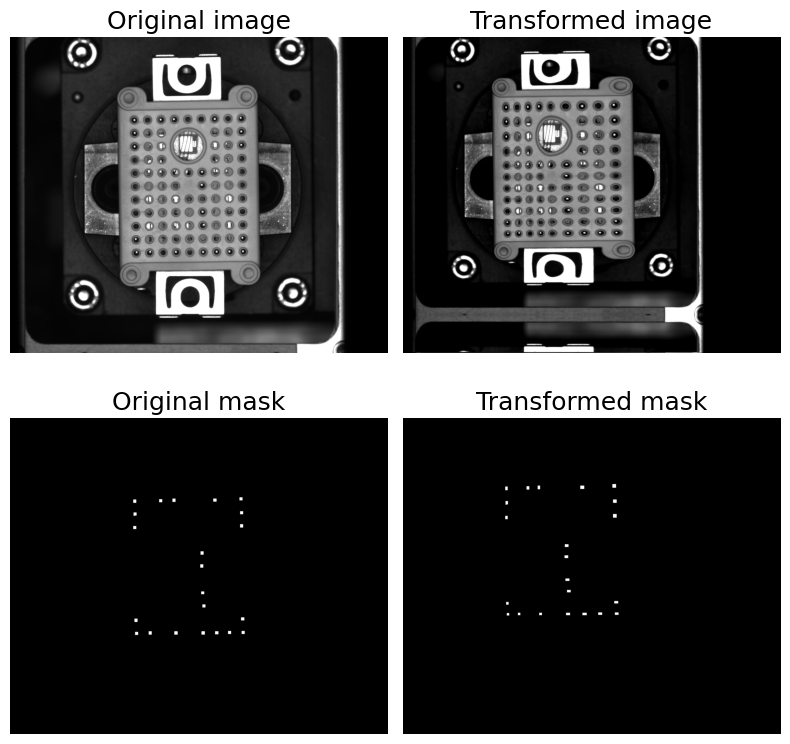

In [388]:
preprocess_obj.show_aug(image=im, mask=msk, original_image=img_.numpy(), original_mask=lbl_.numpy())

In [345]:
#| export
@ patch_to(Preprocess)
def normalize(
              self,
              image:Union[np.ndarray, tf.Tensor], 
              min=0):
    def _normalize(im):
        img = tf.cast(im, tf.float32)
        return img / 255.0

    if min == 0:
        return _normalize(image)
    else:
        return (_normalize(image) * 2.0) -1.0

In [346]:
norm_img = preprocess_obj.normalize(img)
np_img_ = norm_img.numpy()
test_eq(np_img_.min(),0.0), test_eq(np_img_.max(),1.0);

In [347]:
#| export
@ patch_to(Preprocess)
def process_image_and_mask(
                       self,
                       im_file:str,
                       lbl_file:str,
                       norm:bool=True,
                       one_channel:bool=False,
                       aug_data:bool=True
                       ):
    image,mask = self.read_aug(im_file, lbl_file, one_channel=one_channel, aug=aug_data)
    image, mask = tf.image.resize(image, (self.im_height, self.im_width)), tf.image.resize(mask, (self.im_height, self.im_width))
    if norm:
        image = self.normalize(image)
        mask = self.normalize(mask)
    if one_channel:
        image = tf.reshape(image, (self.im_height, self.im_width, 1,))
        mask = tf.reshape(mask, (self.im_height, self.im_width, 1,))
    else:
        image = tf.reshape(image, (self.im_height, self.im_width, 3,))
        mask = tf.reshape(mask, (self.im_height, self.im_width, 3,))
    return image,mask

In [348]:
im, msk = preprocess_obj.process_image_and_mask(im_file=fn, lbl_file=fn_lbl, norm=True, one_channel=False)

In [349]:
type(im),  type(msk)

(tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor)

In [350]:
test_eq(im.numpy().shape, (IMAGE_HEIGHT,IMAGE_WIDTH,3))
test_eq(msk.numpy().shape, (IMAGE_HEIGHT,IMAGE_WIDTH,3))

# Create dataset

In [389]:
#| export
@ patch_to(Preprocess)
def process_data(
                 self,
                 image,
                 label,
                 norm:bool=True,
                 one_channel:bool=False,
                 aug_data:bool=True):
    #@tf.function
    aug_img, aug_lbl = tf.numpy_function(func=self.process_image_and_mask, inp=[image, label, norm, one_channel, aug_data], Tout=(tf.float32, tf.float32))
    return aug_img, aug_lbl

In [390]:
#| export
@patch_to(Preprocess)
def set_shapes(
              self,
              img, 
              label, 
              img_shape):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label

In [421]:
#| export
@patch_to(Preprocess)
def create_dataset(
                  self,
                  images, labels,
                  train:bool=True,
                  norm:bool=True,
                  aug:bool=True
                  ):
    _dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    _dataset = _dataset.map(partial(self.process_data, aug_data=aug, norm=norm), num_parallel_calls=tf.data.AUTOTUNE)
    
    if self.one_channel:
        _dataset = _dataset.map(partial(self.et_shapes, img_shape=(self.im_height, self.im_width, 1)), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        _dataset = _dataset.map(partial(self.set_shapes, img_shape=(self.im_height, self.im_width, 3)), num_parallel_calls=tf.data.AUTOTUNE)
    if train:
        return  _dataset\
                   .cache()\
                   .shuffle(
                            self.bf_size,
                            reshuffle_each_iteration=True)\
                   .batch(self.bs)\
                   .repeat()\
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
    else:
        #_dataset = _dataset.map(self.process_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
        return  _dataset.batch(self.bs).repeat()


In [425]:
#| export
@patch_to(Preprocess)
def create_train_test_dataset(self):
    self.train_dataset = self.create_dataset(
                                            images=self.train_images, 
                                            labels=self.train_labels,
                                            norm=True,
                                            aug=True,
                                            train=True)
    self.test_dataset = self.create_dataset(
                                           images=self.test_images,
                                           labels=self.test_labels,
                                           norm=True,
                                           aug=False,
                                           train=False)
    return self.train_dataset, self.test_dataset

In [443]:
def display_image_and_mask(image, mask):
    # Convert the mask to a 3-channel RGB image
    image = image * 255
    mask_rgb = np.zeros_like(image)
    mask = np.where(mask>0.8, 1,0)
    mask_rgb[mask > 0] = [255, 0, 0]  # Set mask pixels to red

    # Overlay the mask on top of the image
    blended = np.zeros_like(image)
    blended += image
    blended += mask_rgb

    # Display the result
    plt.imshow(blended)
    plt.show()

In [439]:
mask_rgb = np.zeros_like(test_image)

In [440]:
mask_rgb[test_mask>0] = [255,0,0]

ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 405 output values where the mask is true

In [434]:
image, mask = next(iter(train_ds))

2023-04-16 18:38:05.196467: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [435]:
test_image = image[0]
test_mask = mask[0]

In [438]:
test_image.shape

TensorShape([224, 224, 3])

In [469]:
display_img_mask(
                  img=test_image,
                  mask=test_mask,
                  overlay_mask=False
                  )

ValueError: cannot reshape array of size 150528 into shape (512,512)

In [463]:
def display_img_mask(img, mask=None,
                     predicted=None,
                     overlay_mask=False,
                     threshold=0.5,
                     threshold_mask=False,
                     invert=False,
                     metrics=[],
                     size=(512, 512),
                     scale=1,
                     addText="",
                     split=False):
   
    # Helper method to convert tensors to numpy
    def _cvtNP(m):
        if m is None:
            return m, m
       
        # Seams to be an tensor, convert it to numpy and scale it to 0..255
        m_scale1 = None
        m_scale255 = None
        if isinstance(m, tf.data.Dataset) or isinstance(m, tf.Tensor):
            m_scale1   = m.numpy()
            m_scale255 = (m * 255).numpy().astype(np.uint8)
        elif isinstance(m, np.ndarray):
           
            if m.dtype in [np.float16, np.float32, np.float64]:
                m_scale255 = (m * 255).astype(np.uint8)
                m_scale1 = m
            elif m.dtype in [np.uint8]:
                m_scale255 = m.copy()
                m_scale1 = m / 255.0
            else:
                raise Exception("unknown dtype:", m.dtype)

        else:
            raise Exception("unknown input type:", type(m))

        m_scale1 = m_scale1.reshape(size)
        m_scale255 = m_scale255.reshape(size)
        return (m_scale1, m_scale255)
   
    # Convert images to numpy and reshape them
    img, imgN       = _cvtNP(img)
    mask, maskN      = _cvtNP(mask)
    predicted, predictedN = _cvtNP(predicted)
   
    # Invert mask and label if needed
    if invert:
        if predicted is not None:
            predicted = 1 - predicted
            predictedN = 255 - predictedN
        if mask is not None:
            mask = 1 - mask
            maskN = 255 - maskN
   
    if threshold_mask:
        mask = np.where(mask>=threshold, 1.0, 0.0)
        maskN = np.where(maskN>=int(threshold*255), 255, 0)
   
    # Calculate metrics
    if predicted is not None and mask is not None:
        if len(metrics):
            addText += "\n"
        for metric in metrics:
            metric.reset_state()
            name = metric.get_config()["name"]
            mm = tf.keras.backend.flatten(mask)
            pp = tf.keras.backend.flatten(predicted)
            value = metric(mm, pp)
            addText += ("{:10.4f} {:s}  \n".format(value.numpy(), name))
       
        # Create color image of escapees and overreject
        ret = np.ones(size + (3,), dtype=np.uint8)
        ret = ret * 255

        M = np.where(mask >= threshold, True, False).reshape(*size)
        R = np.where(predicted >= threshold, True, False).reshape(*size)
       
        TP =  M &  R
        FP = ~M &  R
        TN = ~M & ~R
        FN =  M & ~R

        ret[FP] = [0, 255, 0]
        ret[TP] = [0, 0, 0]
        ret[FN] = [255, 0 , 0]
       

    dpi = float(mpl.rcParams['figure.dpi'])
    fig_size = size[0] / dpi * scale
    font1 = {'family':'monospace', 'size': 12, 'verticalalignment': 'top'}
   
   
    if mask is None:
        fig, axs = pyplot.subplots(1, 1, figsize=(fig_size, fig_size))
        axs.imshow(imgN, cmap="gray")
        axs.text(0,size[0]+80, str(addText), font1)
        axs.title.set_text('Original')
       
    else:
       
        # Overlay
        if overlay_mask:
            o_maskN = np.ones(size + (3,), dtype=np.uint8)
            o_maskN[:, :, 0] = imgN.reshape(*size)
            o_maskN[:, :, 1] = imgN.reshape(*size)
            o_maskN[:, :, 2] = imgN.reshape(*size)
            match = maskN.reshape(*size) > (threshold * 255)
            o_maskN[match] = [0,255,0]
        else:
            o_maskN = np.ones(size + (3,), dtype=np.uint8)
            o_maskN[:, :, 0] = maskN.reshape(*size)
            o_maskN[:, :, 1] = maskN.reshape(*size)
            o_maskN[:, :, 2] = maskN.reshape(*size)
           
           
        if predicted is None:
            fig, axs = pyplot.subplots(1, 2, figsize=(2*fig_size, fig_size))
            axs[0].imshow(imgN, cmap="gray")
            axs[0].title.set_text('Original')
            axs[0].text(0,size[0]+80, str(addText), font1)
            axs[1].imshow(o_maskN)
            axs[1].title.set_text('Mask')
   
        else:
            if split:
                fig, axs = pyplot.subplots(2, 2, figsize=(2*fig_size, 2*fig_size))
                axs[0][0].imshow(imgN, cmap="gray")
                axs[0][0].title.set_text('Original')
                axs[0][0].text(0,size[0]+80, str(addText), font1)
                axs[0][1].imshow(o_maskN)
                axs[0][1].title.set_text('Mask')
                axs[1][0].imshow(ret, cmap="gray")
                axs[1][0].title.set_text('Match')
                axs[1][1].imshow(predictedN, cmap="gray")
                axs[1][1].title.set_text('Prediction')
           
            else:
               
                fig, axs = pyplot.subplots(1, 4, figsize=(4*fig_size, fig_size))
                axs[0].imshow(imgN, cmap="gray")
                axs[0].text(0,size[0]+80, str(addText), font1)
                axs[0].title.set_text('Original')
                axs[1].imshow(o_maskN)
                axs[1].title.set_text('Mask')
                axs[2].imshow(ret, cmap="gray")
                axs[2].title.set_text('Match')
                axs[3].imshow(predictedN, cmap="gray")
                axs[3].title.set_text('Prediction')

In [461]:
def display_image_and_mask(image, mask):
    mask = np.where(mask>0.8, 1.0,0.0)
    # Make a copy of the input image
    image = image * 255
    mask = mask * 255
    
    print(mask.shape)
    image_with_mask = np.copy(image)

    # Create a 3-channel mask from the binary mask
    #mask = np.expand_dims(mask, axis=2)
    #mask = np.repeat(mask, 3, axis=2)

    # Apply the mask to the image
    image_with_mask[mask != 0] = [0, 255, 0]

    # Display the image with the mask overlaid
    plt.imshow(image_with_mask)
    plt.show()

In [462]:
display_image_and_mask(image=test_image, mask=test_mask)

(224, 224, 3)


ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 261 output values where the mask is true

In [ ]:
def show_dataset(ds:tf.data.Dataset):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(8):
        ax = fig.add_subplot(4, 2, i+1, xticks=[], yticks=[])
        
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

In [426]:
#| hide
train_ds, test_ds = preprocess_obj.create_train_test_dataset()

In [431]:
image_, mask_ =next(iter(train_ds))

2023-04-16 18:33:07.843372: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [432]:
image_.shape

TensorShape([8, 224, 224, 3])

2023-04-16 18:26:30.059752: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


IndexError: index 8 is out of bounds for axis 0 with size 8

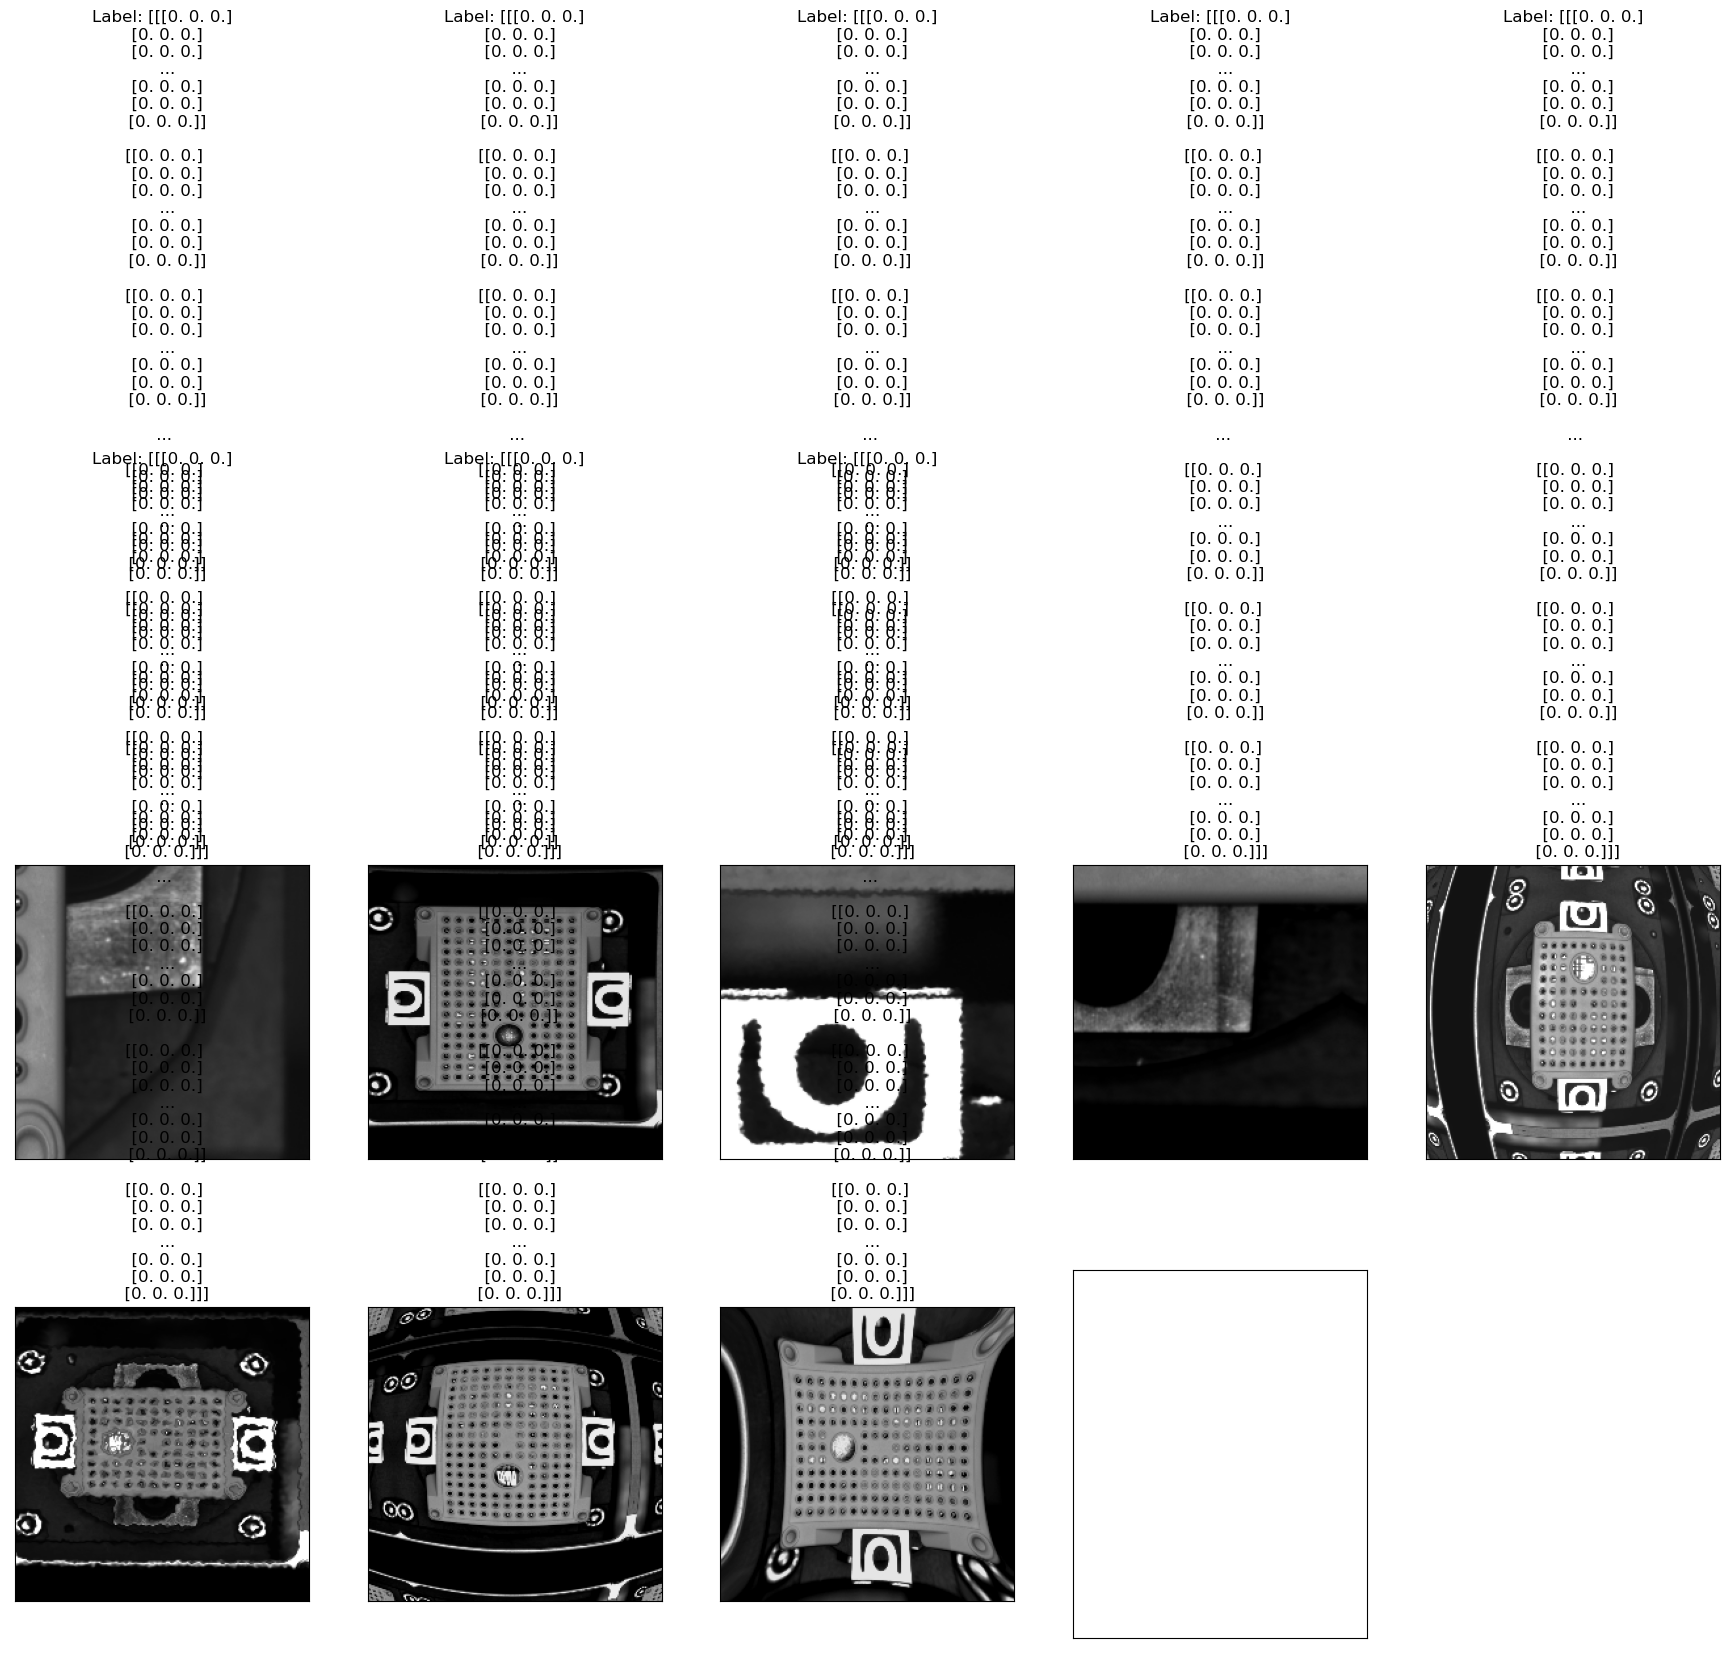

In [430]:
view_image(train_ds)

In [427]:
#| hide
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))>

In [64]:
#| export
def foo(): pass

In [428]:
#| hide
import nbdev; nbdev.nbdev_export()